# Dogs vs. Cats Problem

우선 Train 20000(cat: 10000, dog: 10000), Validate 5000(cat: 2500, dog: 2500)으로 학습시켜본다.

## Colab Data Load

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# 2. Get the file
downloaded = drive.CreateFile({'id':'1Y1b49C9LgN7zZZzsvphkCk-o_1WsnjPa'}) # replace the id with id of file you want to access
downloaded.GetContentFile('data25000.zip')

In [0]:
!mkdir checkpoint

In [0]:
downloaded = drive.CreateFile({'id':'1CPIGvkDNcRRY-wzL2eNck-SKqFUKgzXs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('./checkpoint/ckpt.t7')

In [0]:
downloaded = drive.CreateFile({'id':'1OhiL4UIp4lX810gtzvyqYLerQOt-E36C'}) # replace the id with id of file you want to access
downloaded.GetContentFile('./checkpoint/test_stat.csv')

In [0]:
rm -rd data

## Zip File Extraction

In [0]:
import zipfile
import os, os.path

In [0]:
DataPath = './data'

In [0]:
objZip = zipfile.ZipFile('./data25000.zip')
objZip.extractall(DataPath)

In [0]:
from IPython.display import Image

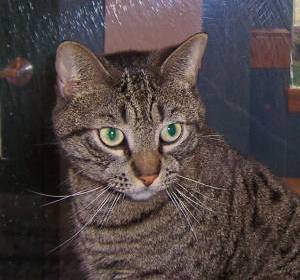

In [29]:
Image('./data/Train/cat/cat.1.jpg')

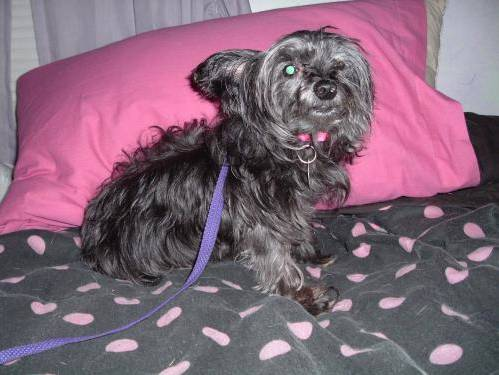

In [30]:
Image('./data/Train/dog/dog.0.jpg')

In [31]:
print("[TestData] Train cat : [%d]" % len(os.listdir('./data/Train/cat/') ) )
print("[TestData] Train dog : [%d]" % len(os.listdir('./data/Train/dog/') ) )

print("[ValidData] Valid cat : [%d]" % len(os.listdir('./data/Valid/cat/') ) )
print("[ValidData] Valid dog : [%d]" % len(os.listdir('./data/Valid/dog/') ) )

[TestData] Train cat : [10000]
[TestData] Train dog : [10000]
[ValidData] Valid cat : [2500]
[ValidData] Valid dog : [2500]


Input Data Load SuccessFully!

## Model Construction

In [15]:
# torch 0.4 install for torch.no_grad()
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
# !pip3 install torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5b06a000 @  0x7f53f34601c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [0]:
import torch
import torchvision
import torchvision.models as models

In [0]:
# net = models.resnet50(num_classes=2)
net = models.resnet18(num_classes=2)
# net = models.vgg.vgg19_bn()
# net.children

In [0]:
import torch.nn as nn

In [0]:
from torch.autograd import Variable 

In [5]:
net = net.cuda()
x = Variable(torch.randn(2,3,224,224))
x = x.to('cuda')
y = net(x)
print(y)

tensor([[ 0.5740,  0.0239],
        [ 0.6834,  0.1526]], device='cuda:0')


## Apply Data to Model

reference : https://github.com/kuangliu/pytorch-cifar

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import time

In [0]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.48833174, 0.4550874,  0.41697174), (0.2562639,  0.24982646, 0.25225964)),
])

In [0]:
trainset = torchvision.datasets.ImageFolder(root='./data/Train', transform=transform_train)

In [9]:
trainset.classes

['cat', 'dog']

In [10]:
trainset.class_to_idx

{'cat': 0, 'dog': 1}

In [0]:
# trainset.imgs

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=2)

In [0]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer를 개선해본다. [ https://pytorch.org/docs/master/optim.html ]


In [0]:
import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
# Training
def train(epoch):
    start_time = time.time()
    print('\nEpoch: %d' % epoch)
    print('< Training >')
    net.train()
    train_loss = 0
    correct = 0.0
    total = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        #inputs, targets = Variable.cuda(inputs), Variable.cuda(targets)
        # print(batch_idx)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # train_loss += loss.item()
        train_loss += loss
        _, predicted = outputs.max(1)
        total += targets.size(0)
        
        # correct += predicted.eq(targets).sum().item()
        correct += predicted.eq(targets).float().sum()
        # correct += predicted.eq(targets).long().sum()
                
        if batch_idx % 10 == 9:
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print("--- %.2f seconds ---" %(time.time() - start_time))
    
    # Save Train Statistics
    epoch_acc = correct/total
    epoch_loss = train_loss/(batch_idx+1)
    train_acc_collect.append(epoch_acc.cpu().numpy().item(0))
    train_loss_collect.append(epoch_loss.detach().cpu().numpy().item(0))

In [0]:
testset = torchvision.datasets.ImageFolder(root='./data/Valid', transform=transform_train)

In [17]:
testset.classes

['cat', 'dog']

In [18]:
testset.class_to_idx

{'cat': 0, 'dog': 1}

In [0]:
# testset.imgs

In [0]:
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=False, num_workers=2)

torch.no_grad()를 쓰지 않으면 net.eval() 시에 memory error가 발생한다. (https://github.com/pytorch/pytorch/issues/4932)

torch.no_grad()는 torch 0.4 버젼부터 제공한다. 

colab의 torch 기본 설치는 0.3 버젼이므로 수동 설치를 해야한다.
(https://discuss.pytorch.org/t/pytorch-0-4-0-on-google-colab/17329)

In [0]:
#@title 기본 제목 텍스트
def test(epoch):
    global best_acc
    global best_epoch
    start_time = time.time()
    print('< Evaluation >')
    net.eval()
    test_loss = 0
    correct = 0.0
    total = 0.0
    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(testloader):
          inputs, targets = inputs.to(device), targets.to(device)
          #inputs, targets = Variable.cuda(inputs), Variable.cuda(targets)
          # print(inputs)
          # print(batch_idx)
          outputs = net(inputs)
          loss = criterion(outputs, targets)
          
          # test_loss += loss.item()
          test_loss += loss
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).float().sum()
          # correct += predicted.eq(targets).long().sum()
          
          if batch_idx % 10 == 9:
            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('\nSaving.. = [%d, %.3f]\n'% (epoch, acc))
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
        best_epoch = epoch
    
    
    print("--- %.2f seconds ---" %(time.time() - start_time))
    
    # Save Eval Statistics
    epoch_acc = correct/total
    epoch_loss = test_loss/(batch_idx+1)
    valid_acc_collect.append(epoch_acc.cpu().numpy().item(0))
    valid_loss_collect.append(epoch_loss.detach().cpu().numpy().item(0))

In [22]:
import pandas as pd
import os, os.path

#@title Resume 여부
resume = True #@param {type:"boolean"}

# 그래프를 위하여 pandas에 accuracy와 loss를 저장한다.
train_acc_collect = []
valid_acc_collect = []

train_loss_collect = []
valid_loss_collect = []

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    best_epoch = start_epoch
    print('==> best_acc : ', best_acc)
    
    # Load Train Stat
    train_stat = pd.read_csv("./checkpoint/test_stat.csv")
    train_acc_collect = train_stat['TrainAccRate'].tolist()
    valid_acc_collect = train_stat['ValidAccRate'].tolist()
    train_loss_collect = train_stat['TrainLoss'].tolist()
    valid_loss_collect = train_stat['ValidLoss'].tolist()
    
    print('==> Done..')
else:
    train_stat = pd.DataFrame()
    start_epoch = 0
    best_acc = 0
    best_epoch = 0
    

==> Resuming from checkpoint..
==> best_acc :  tensor(94.3800, device='cuda:0')
==> Done..


In [23]:
for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)


Epoch: 43
< Training >
Loss: 0.001 | Acc: 100.000% (200/200)
Loss: 0.001 | Acc: 100.000% (400/400)
Loss: 0.007 | Acc: 99.667% (598/600)
Loss: 0.006 | Acc: 99.750% (798/800)
Loss: 0.007 | Acc: 99.700% (997/1000)
Loss: 0.006 | Acc: 99.750% (1197/1200)
Loss: 0.005 | Acc: 99.786% (1397/1400)
Loss: 0.005 | Acc: 99.812% (1597/1600)
Loss: 0.006 | Acc: 99.778% (1796/1800)
Loss: 0.009 | Acc: 99.700% (1994/2000)
Loss: 0.010 | Acc: 99.682% (2193/2200)
Loss: 0.009 | Acc: 99.708% (2393/2400)
Loss: 0.010 | Acc: 99.654% (2591/2600)
Loss: 0.011 | Acc: 99.643% (2790/2800)
Loss: 0.010 | Acc: 99.667% (2990/3000)
Loss: 0.010 | Acc: 99.688% (3190/3200)
Loss: 0.010 | Acc: 99.676% (3389/3400)
Loss: 0.011 | Acc: 99.611% (3586/3600)
Loss: 0.010 | Acc: 99.632% (3786/3800)
Loss: 0.010 | Acc: 99.650% (3986/4000)
Loss: 0.010 | Acc: 99.667% (4186/4200)
Loss: 0.009 | Acc: 99.682% (4386/4400)
Loss: 0.009 | Acc: 99.696% (4586/4600)
Loss: 0.009 | Acc: 99.708% (4786/4800)
Loss: 0.009 | Acc: 99.720% (4986/5000)
Loss: 0.

Loss: 0.008 | Acc: 99.725% (14161/14200)
Loss: 0.008 | Acc: 99.729% (14361/14400)
Loss: 0.008 | Acc: 99.733% (14561/14600)
Loss: 0.008 | Acc: 99.736% (14761/14800)
Loss: 0.008 | Acc: 99.740% (14961/15000)
Loss: 0.008 | Acc: 99.743% (15161/15200)
Loss: 0.008 | Acc: 99.747% (15361/15400)
Loss: 0.008 | Acc: 99.750% (15561/15600)
Loss: 0.008 | Acc: 99.753% (15761/15800)
Loss: 0.008 | Acc: 99.756% (15961/16000)
Loss: 0.008 | Acc: 99.759% (16161/16200)
Loss: 0.008 | Acc: 99.762% (16361/16400)
Loss: 0.007 | Acc: 99.765% (16561/16600)
Loss: 0.007 | Acc: 99.768% (16761/16800)
Loss: 0.007 | Acc: 99.771% (16961/17000)
Loss: 0.007 | Acc: 99.767% (17160/17200)
Loss: 0.007 | Acc: 99.770% (17360/17400)
Loss: 0.007 | Acc: 99.773% (17560/17600)
Loss: 0.007 | Acc: 99.775% (17760/17800)
Loss: 0.007 | Acc: 99.778% (17960/18000)
Loss: 0.007 | Acc: 99.780% (18160/18200)
Loss: 0.007 | Acc: 99.783% (18360/18400)
Loss: 0.007 | Acc: 99.785% (18560/18600)
Loss: 0.007 | Acc: 99.787% (18760/18800)
Loss: 0.007 | Ac

Loss: 0.001 | Acc: 99.967% (2999/3000)
Loss: 0.001 | Acc: 99.969% (3199/3200)
Loss: 0.001 | Acc: 99.971% (3399/3400)
Loss: 0.001 | Acc: 99.972% (3599/3600)
Loss: 0.001 | Acc: 99.974% (3799/3800)
Loss: 0.001 | Acc: 99.950% (3998/4000)
Loss: 0.001 | Acc: 99.952% (4198/4200)
Loss: 0.001 | Acc: 99.955% (4398/4400)
Loss: 0.002 | Acc: 99.935% (4597/4600)
Loss: 0.003 | Acc: 99.896% (4795/4800)
Loss: 0.004 | Acc: 99.880% (4994/5000)
Loss: 0.004 | Acc: 99.885% (5194/5200)
Loss: 0.004 | Acc: 99.870% (5393/5400)
Loss: 0.004 | Acc: 99.857% (5592/5600)
Loss: 0.004 | Acc: 99.862% (5792/5800)
Loss: 0.005 | Acc: 99.833% (5990/6000)
Loss: 0.005 | Acc: 99.839% (6190/6200)
Loss: 0.005 | Acc: 99.844% (6390/6400)
Loss: 0.005 | Acc: 99.848% (6590/6600)
Loss: 0.005 | Acc: 99.838% (6789/6800)
Loss: 0.005 | Acc: 99.843% (6989/7000)
Loss: 0.005 | Acc: 99.833% (7188/7200)
Loss: 0.005 | Acc: 99.824% (7387/7400)
Loss: 0.006 | Acc: 99.803% (7585/7600)
Loss: 0.006 | Acc: 99.795% (7784/7800)
Loss: 0.007 | Acc: 99.750

Loss: 0.011 | Acc: 99.594% (16931/17000)
Loss: 0.011 | Acc: 99.593% (17130/17200)
Loss: 0.011 | Acc: 99.592% (17329/17400)
Loss: 0.010 | Acc: 99.597% (17529/17600)
Loss: 0.010 | Acc: 99.601% (17729/17800)
Loss: 0.010 | Acc: 99.606% (17929/18000)
Loss: 0.010 | Acc: 99.604% (18128/18200)
Loss: 0.010 | Acc: 99.609% (18328/18400)
Loss: 0.010 | Acc: 99.608% (18527/18600)
Loss: 0.010 | Acc: 99.612% (18727/18800)
Loss: 0.010 | Acc: 99.616% (18927/19000)
Loss: 0.010 | Acc: 99.615% (19126/19200)
Loss: 0.010 | Acc: 99.619% (19326/19400)
Loss: 0.010 | Acc: 99.617% (19525/19600)
Loss: 0.010 | Acc: 99.621% (19725/19800)
Loss: 0.010 | Acc: 99.620% (19924/20000)
--- 219.17 seconds ---
< Evaluation >
Loss: 0.312 | Acc: 94.000% (188/200)
Loss: 0.313 | Acc: 94.500% (378/400)
Loss: 0.273 | Acc: 94.500% (567/600)
Loss: 0.311 | Acc: 93.875% (751/800)
Loss: 0.313 | Acc: 93.700% (937/1000)
Loss: 0.288 | Acc: 94.167% (1130/1200)
Loss: 0.321 | Acc: 93.714% (1312/1400)
Loss: 0.351 | Acc: 93.312% (1493/1600)
Los

Loss: 0.006 | Acc: 99.776% (5787/5800)
Loss: 0.006 | Acc: 99.783% (5987/6000)
Loss: 0.006 | Acc: 99.790% (6187/6200)
Loss: 0.006 | Acc: 99.781% (6386/6400)
Loss: 0.006 | Acc: 99.788% (6586/6600)
Loss: 0.006 | Acc: 99.794% (6786/6800)
Loss: 0.006 | Acc: 99.800% (6986/7000)
Loss: 0.006 | Acc: 99.806% (7186/7200)
Loss: 0.005 | Acc: 99.811% (7386/7400)
Loss: 0.005 | Acc: 99.816% (7586/7600)
Loss: 0.005 | Acc: 99.821% (7786/7800)
Loss: 0.005 | Acc: 99.813% (7985/8000)
Loss: 0.005 | Acc: 99.817% (8185/8200)
Loss: 0.006 | Acc: 99.810% (8384/8400)
Loss: 0.006 | Acc: 99.802% (8583/8600)
Loss: 0.006 | Acc: 99.807% (8783/8800)
Loss: 0.006 | Acc: 99.811% (8983/9000)
Loss: 0.006 | Acc: 99.815% (9183/9200)
Loss: 0.006 | Acc: 99.809% (9382/9400)
Loss: 0.006 | Acc: 99.802% (9581/9600)
Loss: 0.006 | Acc: 99.806% (9781/9800)
Loss: 0.006 | Acc: 99.810% (9981/10000)
Loss: 0.006 | Acc: 99.804% (10180/10200)
Loss: 0.006 | Acc: 99.808% (10380/10400)
Loss: 0.006 | Acc: 99.802% (10579/10600)
Loss: 0.006 | Acc:

Loss: 0.006 | Acc: 99.747% (19750/19800)
Loss: 0.007 | Acc: 99.730% (19946/20000)
--- 218.76 seconds ---
< Evaluation >
Loss: 0.787 | Acc: 85.500% (171/200)
Loss: 0.795 | Acc: 87.000% (348/400)
Loss: 0.669 | Acc: 88.500% (531/600)
Loss: 0.753 | Acc: 87.375% (699/800)
Loss: 0.780 | Acc: 87.300% (873/1000)
Loss: 0.759 | Acc: 87.000% (1044/1200)
Loss: 0.808 | Acc: 87.143% (1220/1400)
Loss: 0.832 | Acc: 86.688% (1387/1600)
Loss: 0.800 | Acc: 87.056% (1567/1800)
Loss: 0.770 | Acc: 87.500% (1750/2000)
Loss: 0.739 | Acc: 87.727% (1930/2200)
Loss: 0.754 | Acc: 87.583% (2102/2400)
Loss: 0.720 | Acc: 87.923% (2286/2600)
Loss: 0.674 | Acc: 88.607% (2481/2800)
Loss: 0.637 | Acc: 89.133% (2674/3000)
Loss: 0.605 | Acc: 89.594% (2867/3200)
Loss: 0.588 | Acc: 89.765% (3052/3400)
Loss: 0.561 | Acc: 90.194% (3247/3600)
Loss: 0.540 | Acc: 90.474% (3438/3800)
Loss: 0.522 | Acc: 90.725% (3629/4000)
Loss: 0.504 | Acc: 91.024% (3823/4200)
Loss: 0.485 | Acc: 91.341% (4019/4400)
Loss: 0.471 | Acc: 91.587% (421

Loss: 0.011 | Acc: 99.640% (8569/8600)
Loss: 0.011 | Acc: 99.648% (8769/8800)
Loss: 0.011 | Acc: 99.656% (8969/9000)
Loss: 0.010 | Acc: 99.663% (9169/9200)
Loss: 0.010 | Acc: 99.670% (9369/9400)
Loss: 0.010 | Acc: 99.677% (9569/9600)
Loss: 0.010 | Acc: 99.684% (9769/9800)
Loss: 0.010 | Acc: 99.690% (9969/10000)
Loss: 0.010 | Acc: 99.696% (10169/10200)
Loss: 0.009 | Acc: 99.702% (10369/10400)
Loss: 0.009 | Acc: 99.708% (10569/10600)
Loss: 0.009 | Acc: 99.713% (10769/10800)
Loss: 0.009 | Acc: 99.709% (10968/11000)
Loss: 0.009 | Acc: 99.714% (11168/11200)
Loss: 0.009 | Acc: 99.711% (11367/11400)
Loss: 0.009 | Acc: 99.707% (11566/11600)
Loss: 0.009 | Acc: 99.712% (11766/11800)
Loss: 0.009 | Acc: 99.708% (11965/12000)
Loss: 0.009 | Acc: 99.713% (12165/12200)
Loss: 0.009 | Acc: 99.718% (12365/12400)
Loss: 0.009 | Acc: 99.722% (12565/12600)
Loss: 0.009 | Acc: 99.727% (12765/12800)
Loss: 0.008 | Acc: 99.731% (12965/13000)
Loss: 0.008 | Acc: 99.727% (13164/13200)
Loss: 0.008 | Acc: 99.731% (133

Loss: 0.392 | Acc: 93.625% (2247/2400)
Loss: 0.378 | Acc: 93.654% (2435/2600)
Loss: 0.358 | Acc: 93.893% (2629/2800)
Loss: 0.343 | Acc: 94.133% (2824/3000)
Loss: 0.338 | Acc: 94.125% (3012/3200)
Loss: 0.342 | Acc: 94.118% (3200/3400)
Loss: 0.328 | Acc: 94.278% (3394/3600)
Loss: 0.318 | Acc: 94.368% (3586/3800)
Loss: 0.312 | Acc: 94.425% (3777/4000)
Loss: 0.310 | Acc: 94.452% (3967/4200)
Loss: 0.300 | Acc: 94.614% (4163/4400)
Loss: 0.296 | Acc: 94.696% (4356/4600)
Loss: 0.296 | Acc: 94.646% (4543/4800)
Loss: 0.295 | Acc: 94.640% (4732/5000)

Saving.. = [46, 94.640]

--- 34.91 seconds ---

Epoch: 47
< Training >
Loss: 0.000 | Acc: 100.000% (200/200)
Loss: 0.002 | Acc: 99.750% (399/400)
Loss: 0.002 | Acc: 99.833% (599/600)
Loss: 0.001 | Acc: 99.875% (799/800)
Loss: 0.001 | Acc: 99.900% (999/1000)
Loss: 0.001 | Acc: 99.917% (1199/1200)
Loss: 0.001 | Acc: 99.929% (1399/1400)
Loss: 0.001 | Acc: 99.938% (1599/1600)
Loss: 0.001 | Acc: 99.944% (1799/1800)
Loss: 0.001 | Acc: 99.950% (1999/2000)


Loss: 0.009 | Acc: 99.732% (11170/11200)
Loss: 0.009 | Acc: 99.737% (11370/11400)
Loss: 0.009 | Acc: 99.733% (11569/11600)
Loss: 0.009 | Acc: 99.737% (11769/11800)
Loss: 0.009 | Acc: 99.725% (11967/12000)
Loss: 0.009 | Acc: 99.730% (12167/12200)
Loss: 0.009 | Acc: 99.734% (12367/12400)
Loss: 0.008 | Acc: 99.738% (12567/12600)
Loss: 0.008 | Acc: 99.742% (12767/12800)
Loss: 0.008 | Acc: 99.746% (12967/13000)
Loss: 0.008 | Acc: 99.750% (13167/13200)
Loss: 0.008 | Acc: 99.746% (13366/13400)
Loss: 0.008 | Acc: 99.750% (13566/13600)
Loss: 0.008 | Acc: 99.746% (13765/13800)
Loss: 0.008 | Acc: 99.736% (13963/14000)
Loss: 0.008 | Acc: 99.732% (14162/14200)
Loss: 0.008 | Acc: 99.736% (14362/14400)
Loss: 0.008 | Acc: 99.740% (14562/14600)
Loss: 0.008 | Acc: 99.743% (14762/14800)
Loss: 0.008 | Acc: 99.740% (14961/15000)
Loss: 0.008 | Acc: 99.743% (15161/15200)
Loss: 0.008 | Acc: 99.734% (15359/15400)
Loss: 0.008 | Acc: 99.737% (15559/15600)
Loss: 0.008 | Acc: 99.741% (15759/15800)
Loss: 0.008 | Ac

Loss: 0.306 | Acc: 94.120% (4706/5000)
--- 34.82 seconds ---

Epoch: 48
< Training >
Loss: 0.002 | Acc: 100.000% (200/200)
Loss: 0.002 | Acc: 100.000% (400/400)
Loss: 0.009 | Acc: 99.833% (599/600)
Loss: 0.007 | Acc: 99.875% (799/800)
Loss: 0.008 | Acc: 99.700% (997/1000)
Loss: 0.007 | Acc: 99.667% (1196/1200)
Loss: 0.007 | Acc: 99.643% (1395/1400)
Loss: 0.007 | Acc: 99.625% (1594/1600)
Loss: 0.006 | Acc: 99.667% (1794/1800)
Loss: 0.007 | Acc: 99.650% (1993/2000)
Loss: 0.009 | Acc: 99.636% (2192/2200)
Loss: 0.008 | Acc: 99.667% (2392/2400)
Loss: 0.008 | Acc: 99.692% (2592/2600)
Loss: 0.008 | Acc: 99.679% (2791/2800)
Loss: 0.008 | Acc: 99.700% (2991/3000)
Loss: 0.008 | Acc: 99.688% (3190/3200)
Loss: 0.009 | Acc: 99.647% (3388/3400)
Loss: 0.009 | Acc: 99.639% (3587/3600)
Loss: 0.009 | Acc: 99.658% (3787/3800)
Loss: 0.008 | Acc: 99.675% (3987/4000)
Loss: 0.008 | Acc: 99.690% (4187/4200)
Loss: 0.009 | Acc: 99.659% (4385/4400)
Loss: 0.009 | Acc: 99.652% (4584/4600)
Loss: 0.008 | Acc: 99.667

Loss: 0.009 | Acc: 99.696% (13758/13800)
Loss: 0.009 | Acc: 99.679% (13955/14000)
Loss: 0.009 | Acc: 99.683% (14155/14200)
Loss: 0.009 | Acc: 99.681% (14354/14400)
Loss: 0.009 | Acc: 99.685% (14554/14600)
Loss: 0.009 | Acc: 99.682% (14753/14800)
Loss: 0.009 | Acc: 99.687% (14953/15000)
Loss: 0.009 | Acc: 99.691% (15153/15200)
Loss: 0.009 | Acc: 99.695% (15353/15400)
Loss: 0.009 | Acc: 99.692% (15552/15600)
Loss: 0.009 | Acc: 99.696% (15752/15800)
Loss: 0.009 | Acc: 99.694% (15951/16000)
Loss: 0.009 | Acc: 99.698% (16151/16200)
Loss: 0.009 | Acc: 99.689% (16349/16400)
Loss: 0.009 | Acc: 99.687% (16548/16600)
Loss: 0.009 | Acc: 99.685% (16747/16800)
Loss: 0.009 | Acc: 99.682% (16946/17000)
Loss: 0.009 | Acc: 99.674% (17144/17200)
Loss: 0.009 | Acc: 99.667% (17342/17400)
Loss: 0.010 | Acc: 99.665% (17541/17600)
Loss: 0.010 | Acc: 99.669% (17741/17800)
Loss: 0.010 | Acc: 99.672% (17941/18000)
Loss: 0.009 | Acc: 99.676% (18141/18200)
Loss: 0.009 | Acc: 99.679% (18341/18400)
Loss: 0.009 | Ac

Loss: 0.004 | Acc: 99.885% (2597/2600)
Loss: 0.004 | Acc: 99.893% (2797/2800)
Loss: 0.004 | Acc: 99.900% (2997/3000)
Loss: 0.004 | Acc: 99.906% (3197/3200)
Loss: 0.004 | Acc: 99.912% (3397/3400)
Loss: 0.004 | Acc: 99.889% (3596/3600)
Loss: 0.006 | Acc: 99.842% (3794/3800)
Loss: 0.006 | Acc: 99.850% (3994/4000)
Loss: 0.009 | Acc: 99.833% (4193/4200)
Loss: 0.008 | Acc: 99.841% (4393/4400)
Loss: 0.010 | Acc: 99.804% (4591/4600)
Loss: 0.009 | Acc: 99.812% (4791/4800)
Loss: 0.009 | Acc: 99.820% (4991/5000)
Loss: 0.009 | Acc: 99.808% (5190/5200)
Loss: 0.009 | Acc: 99.796% (5389/5400)
Loss: 0.009 | Acc: 99.804% (5589/5600)
Loss: 0.009 | Acc: 99.793% (5788/5800)
Loss: 0.009 | Acc: 99.800% (5988/6000)
Loss: 0.009 | Acc: 99.790% (6187/6200)
Loss: 0.009 | Acc: 99.797% (6387/6400)
Loss: 0.009 | Acc: 99.788% (6586/6600)
Loss: 0.008 | Acc: 99.794% (6786/6800)
Loss: 0.008 | Acc: 99.800% (6986/7000)
Loss: 0.008 | Acc: 99.806% (7186/7200)
Loss: 0.008 | Acc: 99.811% (7386/7400)
Loss: 0.008 | Acc: 99.803

Loss: 0.007 | Acc: 99.795% (16566/16600)
Loss: 0.007 | Acc: 99.774% (16762/16800)
Loss: 0.007 | Acc: 99.776% (16962/17000)
Loss: 0.007 | Acc: 99.773% (17161/17200)
Loss: 0.007 | Acc: 99.770% (17360/17400)
Loss: 0.007 | Acc: 99.750% (17556/17600)
Loss: 0.008 | Acc: 99.742% (17754/17800)
Loss: 0.007 | Acc: 99.744% (17954/18000)
Loss: 0.008 | Acc: 99.742% (18153/18200)
Loss: 0.008 | Acc: 99.745% (18353/18400)
Loss: 0.008 | Acc: 99.742% (18552/18600)
Loss: 0.008 | Acc: 99.745% (18752/18800)
Loss: 0.008 | Acc: 99.742% (18951/19000)
Loss: 0.008 | Acc: 99.740% (19150/19200)
Loss: 0.008 | Acc: 99.737% (19349/19400)
Loss: 0.008 | Acc: 99.740% (19549/19600)
Loss: 0.008 | Acc: 99.737% (19748/19800)
Loss: 0.008 | Acc: 99.735% (19947/20000)
--- 218.24 seconds ---
< Evaluation >
Loss: 0.316 | Acc: 92.000% (184/200)
Loss: 0.348 | Acc: 92.750% (371/400)
Loss: 0.337 | Acc: 92.500% (555/600)
Loss: 0.411 | Acc: 91.500% (732/800)
Loss: 0.412 | Acc: 91.900% (919/1000)
Loss: 0.383 | Acc: 92.500% (1110/1200)

Loss: 0.007 | Acc: 99.833% (5391/5400)
Loss: 0.007 | Acc: 99.839% (5591/5600)
Loss: 0.007 | Acc: 99.845% (5791/5800)
Loss: 0.007 | Acc: 99.850% (5991/6000)
Loss: 0.006 | Acc: 99.855% (6191/6200)
Loss: 0.006 | Acc: 99.859% (6391/6400)
Loss: 0.006 | Acc: 99.864% (6591/6600)
Loss: 0.006 | Acc: 99.868% (6791/6800)
Loss: 0.006 | Acc: 99.871% (6991/7000)
Loss: 0.006 | Acc: 99.861% (7190/7200)
Loss: 0.006 | Acc: 99.865% (7390/7400)
Loss: 0.005 | Acc: 99.868% (7590/7600)
Loss: 0.005 | Acc: 99.872% (7790/7800)
Loss: 0.005 | Acc: 99.875% (7990/8000)
Loss: 0.005 | Acc: 99.866% (8189/8200)
Loss: 0.005 | Acc: 99.869% (8389/8400)
Loss: 0.006 | Acc: 99.860% (8588/8600)
Loss: 0.006 | Acc: 99.841% (8786/8800)
Loss: 0.006 | Acc: 99.844% (8986/9000)
Loss: 0.006 | Acc: 99.837% (9185/9200)
Loss: 0.006 | Acc: 99.830% (9384/9400)
Loss: 0.006 | Acc: 99.833% (9584/9600)
Loss: 0.006 | Acc: 99.827% (9783/9800)
Loss: 0.006 | Acc: 99.820% (9982/10000)
Loss: 0.006 | Acc: 99.814% (10181/10200)
Loss: 0.006 | Acc: 99.

Loss: 0.004 | Acc: 99.887% (19378/19400)
Loss: 0.004 | Acc: 99.883% (19577/19600)
Loss: 0.004 | Acc: 99.884% (19777/19800)
Loss: 0.004 | Acc: 99.885% (19977/20000)
--- 217.93 seconds ---
< Evaluation >
Loss: 0.267 | Acc: 95.000% (190/200)
Loss: 0.331 | Acc: 95.500% (382/400)
Loss: 0.270 | Acc: 95.167% (571/600)
Loss: 0.319 | Acc: 94.000% (752/800)
Loss: 0.319 | Acc: 94.100% (941/1000)
Loss: 0.286 | Acc: 94.417% (1133/1200)
Loss: 0.324 | Acc: 94.000% (1316/1400)
Loss: 0.322 | Acc: 94.062% (1505/1600)
Loss: 0.304 | Acc: 94.222% (1696/1800)
Loss: 0.294 | Acc: 94.250% (1885/2000)
Loss: 0.274 | Acc: 94.591% (2081/2200)
Loss: 0.284 | Acc: 94.542% (2269/2400)
Loss: 0.281 | Acc: 94.538% (2458/2600)
Loss: 0.279 | Acc: 94.429% (2644/2800)
Loss: 0.274 | Acc: 94.467% (2834/3000)
Loss: 0.278 | Acc: 94.406% (3021/3200)
Loss: 0.307 | Acc: 94.147% (3201/3400)
Loss: 0.303 | Acc: 93.972% (3383/3600)
Loss: 0.302 | Acc: 93.947% (3570/3800)
Loss: 0.300 | Acc: 93.875% (3755/4000)
Loss: 0.302 | Acc: 93.762% 

Loss: 0.013 | Acc: 99.512% (8160/8200)
Loss: 0.012 | Acc: 99.524% (8360/8400)
Loss: 0.012 | Acc: 99.535% (8560/8600)
Loss: 0.012 | Acc: 99.534% (8759/8800)
Loss: 0.012 | Acc: 99.544% (8959/9000)
Loss: 0.012 | Acc: 99.554% (9159/9200)
Loss: 0.012 | Acc: 99.564% (9359/9400)
Loss: 0.012 | Acc: 99.552% (9557/9600)
Loss: 0.011 | Acc: 99.561% (9757/9800)
Loss: 0.011 | Acc: 99.560% (9956/10000)
Loss: 0.011 | Acc: 99.569% (10156/10200)
Loss: 0.011 | Acc: 99.558% (10354/10400)
Loss: 0.012 | Acc: 99.557% (10553/10600)
Loss: 0.012 | Acc: 99.565% (10753/10800)
Loss: 0.011 | Acc: 99.573% (10953/11000)
Loss: 0.011 | Acc: 99.571% (11152/11200)
Loss: 0.011 | Acc: 99.570% (11351/11400)
Loss: 0.011 | Acc: 99.578% (11551/11600)
Loss: 0.011 | Acc: 99.576% (11750/11800)
Loss: 0.011 | Acc: 99.575% (11949/12000)
Loss: 0.011 | Acc: 99.582% (12149/12200)
Loss: 0.011 | Acc: 99.589% (12349/12400)
Loss: 0.011 | Acc: 99.595% (12549/12600)
Loss: 0.010 | Acc: 99.602% (12749/12800)
Loss: 0.010 | Acc: 99.608% (12949/1

Loss: 0.189 | Acc: 95.800% (1916/2000)
Loss: 0.172 | Acc: 96.182% (2116/2200)
Loss: 0.188 | Acc: 96.125% (2307/2400)
Loss: 0.213 | Acc: 95.769% (2490/2600)
Loss: 0.231 | Acc: 95.286% (2668/2800)
Loss: 0.246 | Acc: 95.067% (2852/3000)
Loss: 0.259 | Acc: 94.844% (3035/3200)
Loss: 0.291 | Acc: 94.265% (3205/3400)
Loss: 0.303 | Acc: 93.889% (3380/3600)
Loss: 0.303 | Acc: 93.763% (3563/3800)
Loss: 0.314 | Acc: 93.525% (3741/4000)
Loss: 0.324 | Acc: 93.310% (3919/4200)
Loss: 0.328 | Acc: 93.227% (4102/4400)
Loss: 0.332 | Acc: 93.217% (4288/4600)
Loss: 0.344 | Acc: 93.062% (4467/4800)
Loss: 0.352 | Acc: 92.920% (4646/5000)
--- 34.31 seconds ---

Epoch: 52
< Training >
Loss: 0.033 | Acc: 99.000% (198/200)
Loss: 0.023 | Acc: 99.250% (397/400)
Loss: 0.017 | Acc: 99.500% (597/600)
Loss: 0.016 | Acc: 99.375% (795/800)
Loss: 0.014 | Acc: 99.500% (995/1000)
Loss: 0.012 | Acc: 99.583% (1195/1200)
Loss: 0.011 | Acc: 99.643% (1395/1400)
Loss: 0.010 | Acc: 99.625% (1594/1600)
Loss: 0.009 | Acc: 99.667% 

Loss: 0.006 | Acc: 99.791% (10977/11000)
Loss: 0.006 | Acc: 99.795% (11177/11200)
Loss: 0.006 | Acc: 99.789% (11376/11400)
Loss: 0.006 | Acc: 99.793% (11576/11600)
Loss: 0.006 | Acc: 99.797% (11776/11800)
Loss: 0.006 | Acc: 99.800% (11976/12000)
Loss: 0.006 | Acc: 99.803% (12176/12200)
Loss: 0.006 | Acc: 99.806% (12376/12400)
Loss: 0.006 | Acc: 99.802% (12575/12600)
Loss: 0.006 | Acc: 99.789% (12773/12800)
Loss: 0.006 | Acc: 99.792% (12973/13000)
Loss: 0.007 | Acc: 99.765% (13169/13200)
Loss: 0.007 | Acc: 99.761% (13368/13400)
Loss: 0.009 | Acc: 99.743% (13565/13600)
Loss: 0.009 | Acc: 99.732% (13763/13800)
Loss: 0.010 | Acc: 99.714% (13960/14000)
Loss: 0.011 | Acc: 99.697% (14157/14200)
Loss: 0.011 | Acc: 99.694% (14356/14400)
Loss: 0.012 | Acc: 99.671% (14552/14600)
Loss: 0.012 | Acc: 99.655% (14749/14800)
Loss: 0.012 | Acc: 99.640% (14946/15000)
Loss: 0.012 | Acc: 99.632% (15144/15200)
Loss: 0.012 | Acc: 99.636% (15344/15400)
Loss: 0.012 | Acc: 99.635% (15543/15600)
Loss: 0.012 | Ac

Loss: 0.253 | Acc: 94.292% (4526/4800)
Loss: 0.248 | Acc: 94.320% (4716/5000)
--- 34.10 seconds ---

Epoch: 53
< Training >
Loss: 0.002 | Acc: 100.000% (200/200)
Loss: 0.001 | Acc: 100.000% (400/400)
Loss: 0.001 | Acc: 100.000% (600/600)
Loss: 0.001 | Acc: 100.000% (800/800)
Loss: 0.001 | Acc: 100.000% (1000/1000)
Loss: 0.001 | Acc: 100.000% (1200/1200)
Loss: 0.001 | Acc: 100.000% (1400/1400)
Loss: 0.001 | Acc: 100.000% (1600/1600)
Loss: 0.001 | Acc: 100.000% (1800/1800)
Loss: 0.001 | Acc: 100.000% (2000/2000)
Loss: 0.001 | Acc: 100.000% (2200/2200)
Loss: 0.001 | Acc: 99.958% (2399/2400)
Loss: 0.002 | Acc: 99.962% (2599/2600)
Loss: 0.002 | Acc: 99.964% (2799/2800)
Loss: 0.001 | Acc: 99.967% (2999/3000)
Loss: 0.001 | Acc: 99.969% (3199/3200)
Loss: 0.001 | Acc: 99.971% (3399/3400)
Loss: 0.001 | Acc: 99.972% (3599/3600)
Loss: 0.002 | Acc: 99.947% (3798/3800)
Loss: 0.001 | Acc: 99.950% (3998/4000)
Loss: 0.002 | Acc: 99.952% (4198/4200)
Loss: 0.002 | Acc: 99.955% (4398/4400)
Loss: 0.002 | A

Loss: 0.001 | Acc: 99.949% (13593/13600)
Loss: 0.002 | Acc: 99.942% (13792/13800)
Loss: 0.002 | Acc: 99.943% (13992/14000)
Loss: 0.002 | Acc: 99.944% (14192/14200)
Loss: 0.002 | Acc: 99.944% (14392/14400)
Loss: 0.002 | Acc: 99.938% (14591/14600)
Loss: 0.002 | Acc: 99.939% (14791/14800)
Loss: 0.002 | Acc: 99.933% (14990/15000)
Loss: 0.002 | Acc: 99.934% (15190/15200)
Loss: 0.002 | Acc: 99.935% (15390/15400)
Loss: 0.002 | Acc: 99.936% (15590/15600)
Loss: 0.002 | Acc: 99.937% (15790/15800)
Loss: 0.002 | Acc: 99.938% (15990/16000)
Loss: 0.002 | Acc: 99.938% (16190/16200)
Loss: 0.002 | Acc: 99.939% (16390/16400)
Loss: 0.002 | Acc: 99.940% (16590/16600)
Loss: 0.002 | Acc: 99.940% (16790/16800)
Loss: 0.002 | Acc: 99.935% (16989/17000)
Loss: 0.002 | Acc: 99.936% (17189/17200)
Loss: 0.002 | Acc: 99.937% (17389/17400)
Loss: 0.002 | Acc: 99.932% (17588/17600)
Loss: 0.002 | Acc: 99.933% (17788/17800)
Loss: 0.002 | Acc: 99.933% (17988/18000)
Loss: 0.002 | Acc: 99.934% (18188/18200)
Loss: 0.002 | Ac

Loss: 0.009 | Acc: 99.667% (2392/2400)
Loss: 0.008 | Acc: 99.692% (2592/2600)
Loss: 0.008 | Acc: 99.679% (2791/2800)
Loss: 0.008 | Acc: 99.700% (2991/3000)
Loss: 0.008 | Acc: 99.656% (3189/3200)
Loss: 0.008 | Acc: 99.676% (3389/3400)
Loss: 0.008 | Acc: 99.667% (3588/3600)
Loss: 0.008 | Acc: 99.684% (3788/3800)
Loss: 0.007 | Acc: 99.700% (3988/4000)
Loss: 0.007 | Acc: 99.714% (4188/4200)
Loss: 0.008 | Acc: 99.705% (4387/4400)
Loss: 0.007 | Acc: 99.717% (4587/4600)
Loss: 0.007 | Acc: 99.708% (4786/4800)
Loss: 0.008 | Acc: 99.700% (4985/5000)
Loss: 0.007 | Acc: 99.712% (5185/5200)
Loss: 0.007 | Acc: 99.704% (5384/5400)
Loss: 0.008 | Acc: 99.696% (5583/5600)
Loss: 0.009 | Acc: 99.655% (5780/5800)
Loss: 0.009 | Acc: 99.667% (5980/6000)
Loss: 0.009 | Acc: 99.677% (6180/6200)
Loss: 0.008 | Acc: 99.688% (6380/6400)
Loss: 0.009 | Acc: 99.667% (6578/6600)
Loss: 0.009 | Acc: 99.662% (6777/6800)
Loss: 0.009 | Acc: 99.629% (6974/7000)
Loss: 0.009 | Acc: 99.639% (7174/7200)
Loss: 0.010 | Acc: 99.608

Loss: 0.013 | Acc: 99.549% (16326/16400)
Loss: 0.013 | Acc: 99.554% (16526/16600)
Loss: 0.013 | Acc: 99.554% (16725/16800)
Loss: 0.013 | Acc: 99.559% (16925/17000)
Loss: 0.013 | Acc: 99.552% (17123/17200)
Loss: 0.013 | Acc: 99.557% (17323/17400)
Loss: 0.013 | Acc: 99.562% (17523/17600)
Loss: 0.013 | Acc: 99.567% (17723/17800)
Loss: 0.013 | Acc: 99.572% (17923/18000)
Loss: 0.012 | Acc: 99.577% (18123/18200)
Loss: 0.012 | Acc: 99.582% (18323/18400)
Loss: 0.012 | Acc: 99.586% (18523/18600)
Loss: 0.012 | Acc: 99.580% (18721/18800)
Loss: 0.012 | Acc: 99.584% (18921/19000)
Loss: 0.012 | Acc: 99.589% (19121/19200)
Loss: 0.012 | Acc: 99.593% (19321/19400)
Loss: 0.012 | Acc: 99.597% (19521/19600)
Loss: 0.012 | Acc: 99.601% (19721/19800)
Loss: 0.012 | Acc: 99.605% (19921/20000)
--- 217.08 seconds ---
< Evaluation >
Loss: 0.448 | Acc: 90.500% (181/200)
Loss: 0.410 | Acc: 91.250% (365/400)
Loss: 0.358 | Acc: 92.000% (552/600)
Loss: 0.415 | Acc: 91.000% (728/800)
Loss: 0.407 | Acc: 91.500% (915/100

Loss: 0.004 | Acc: 99.865% (5193/5200)
Loss: 0.004 | Acc: 99.870% (5393/5400)
Loss: 0.004 | Acc: 99.875% (5593/5600)
Loss: 0.004 | Acc: 99.879% (5793/5800)
Loss: 0.004 | Acc: 99.883% (5993/6000)
Loss: 0.004 | Acc: 99.887% (6193/6200)
Loss: 0.004 | Acc: 99.891% (6393/6400)
Loss: 0.004 | Acc: 99.894% (6593/6600)
Loss: 0.003 | Acc: 99.897% (6793/6800)
Loss: 0.004 | Acc: 99.886% (6992/7000)
Loss: 0.004 | Acc: 99.889% (7192/7200)
Loss: 0.004 | Acc: 99.892% (7392/7400)
Loss: 0.004 | Acc: 99.882% (7591/7600)
Loss: 0.004 | Acc: 99.872% (7790/7800)
Loss: 0.004 | Acc: 99.875% (7990/8000)
Loss: 0.004 | Acc: 99.854% (8188/8200)
Loss: 0.005 | Acc: 99.857% (8388/8400)
Loss: 0.005 | Acc: 99.849% (8587/8600)
Loss: 0.005 | Acc: 99.852% (8787/8800)
Loss: 0.005 | Acc: 99.844% (8986/9000)
Loss: 0.005 | Acc: 99.848% (9186/9200)
Loss: 0.005 | Acc: 99.851% (9386/9400)
Loss: 0.004 | Acc: 99.854% (9586/9600)
Loss: 0.005 | Acc: 99.847% (9785/9800)
Loss: 0.004 | Acc: 99.850% (9985/10000)
Loss: 0.005 | Acc: 99.84

Loss: 0.006 | Acc: 99.818% (19165/19200)
Loss: 0.006 | Acc: 99.814% (19364/19400)
Loss: 0.006 | Acc: 99.806% (19562/19600)
Loss: 0.006 | Acc: 99.808% (19762/19800)
Loss: 0.006 | Acc: 99.800% (19960/20000)
--- 216.98 seconds ---
< Evaluation >
Loss: 0.499 | Acc: 90.500% (181/200)
Loss: 0.441 | Acc: 92.500% (370/400)
Loss: 0.387 | Acc: 92.333% (554/600)
Loss: 0.442 | Acc: 91.625% (733/800)
Loss: 0.450 | Acc: 92.000% (920/1000)
Loss: 0.409 | Acc: 92.333% (1108/1200)
Loss: 0.433 | Acc: 92.357% (1293/1400)
Loss: 0.431 | Acc: 92.375% (1478/1600)
Loss: 0.425 | Acc: 92.722% (1669/1800)
Loss: 0.401 | Acc: 92.900% (1858/2000)
Loss: 0.376 | Acc: 93.273% (2052/2200)
Loss: 0.386 | Acc: 93.167% (2236/2400)
Loss: 0.384 | Acc: 93.115% (2421/2600)
Loss: 0.373 | Acc: 93.179% (2609/2800)
Loss: 0.362 | Acc: 93.200% (2796/3000)
Loss: 0.359 | Acc: 93.094% (2979/3200)
Loss: 0.367 | Acc: 92.941% (3160/3400)
Loss: 0.358 | Acc: 92.944% (3346/3600)
Loss: 0.350 | Acc: 93.053% (3536/3800)
Loss: 0.349 | Acc: 93.000

Loss: 0.003 | Acc: 99.925% (7994/8000)
Loss: 0.003 | Acc: 99.927% (8194/8200)
Loss: 0.003 | Acc: 99.929% (8394/8400)
Loss: 0.003 | Acc: 99.930% (8594/8600)
Loss: 0.003 | Acc: 99.932% (8794/8800)
Loss: 0.003 | Acc: 99.933% (8994/9000)
Loss: 0.003 | Acc: 99.935% (9194/9200)
Loss: 0.003 | Acc: 99.926% (9393/9400)
Loss: 0.003 | Acc: 99.917% (9592/9600)
Loss: 0.003 | Acc: 99.918% (9792/9800)
Loss: 0.003 | Acc: 99.920% (9992/10000)
Loss: 0.003 | Acc: 99.922% (10192/10200)
Loss: 0.003 | Acc: 99.923% (10392/10400)
Loss: 0.003 | Acc: 99.925% (10592/10600)
Loss: 0.003 | Acc: 99.926% (10792/10800)
Loss: 0.003 | Acc: 99.927% (10992/11000)
Loss: 0.003 | Acc: 99.920% (11191/11200)
Loss: 0.003 | Acc: 99.921% (11391/11400)
Loss: 0.003 | Acc: 99.922% (11591/11600)
Loss: 0.003 | Acc: 99.915% (11790/11800)
Loss: 0.003 | Acc: 99.917% (11990/12000)
Loss: 0.003 | Acc: 99.918% (12190/12200)
Loss: 0.003 | Acc: 99.919% (12390/12400)
Loss: 0.003 | Acc: 99.913% (12589/12600)
Loss: 0.003 | Acc: 99.914% (12789/128

Loss: 0.264 | Acc: 94.722% (1705/1800)
Loss: 0.249 | Acc: 95.000% (1900/2000)
Loss: 0.232 | Acc: 95.273% (2096/2200)
Loss: 0.245 | Acc: 95.167% (2284/2400)
Loss: 0.255 | Acc: 95.154% (2474/2600)
Loss: 0.254 | Acc: 94.893% (2657/2800)
Loss: 0.256 | Acc: 94.833% (2845/3000)
Loss: 0.257 | Acc: 94.750% (3032/3200)
Loss: 0.272 | Acc: 94.441% (3211/3400)
Loss: 0.270 | Acc: 94.361% (3397/3600)
Loss: 0.269 | Acc: 94.237% (3581/3800)
Loss: 0.268 | Acc: 94.150% (3766/4000)
Loss: 0.269 | Acc: 94.143% (3954/4200)
Loss: 0.274 | Acc: 94.023% (4137/4400)
Loss: 0.281 | Acc: 93.978% (4323/4600)
Loss: 0.290 | Acc: 93.792% (4502/4800)
Loss: 0.292 | Acc: 93.780% (4689/5000)
--- 34.09 seconds ---

Epoch: 57
< Training >
Loss: 0.000 | Acc: 100.000% (200/200)
Loss: 0.002 | Acc: 99.750% (399/400)
Loss: 0.002 | Acc: 99.833% (599/600)
Loss: 0.002 | Acc: 99.875% (799/800)
Loss: 0.002 | Acc: 99.900% (999/1000)
Loss: 0.002 | Acc: 99.917% (1199/1200)
Loss: 0.002 | Acc: 99.929% (1399/1400)
Loss: 0.002 | Acc: 99.938%

Loss: 0.002 | Acc: 99.935% (10793/10800)
Loss: 0.002 | Acc: 99.927% (10992/11000)
Loss: 0.002 | Acc: 99.929% (11192/11200)
Loss: 0.002 | Acc: 99.921% (11391/11400)
Loss: 0.002 | Acc: 99.922% (11591/11600)
Loss: 0.002 | Acc: 99.924% (11791/11800)
Loss: 0.002 | Acc: 99.925% (11991/12000)
Loss: 0.002 | Acc: 99.926% (12191/12200)
Loss: 0.002 | Acc: 99.927% (12391/12400)
Loss: 0.002 | Acc: 99.921% (12590/12600)
Loss: 0.002 | Acc: 99.906% (12788/12800)
Loss: 0.002 | Acc: 99.908% (12988/13000)
Loss: 0.002 | Acc: 99.909% (13188/13200)
Loss: 0.002 | Acc: 99.903% (13387/13400)
Loss: 0.002 | Acc: 99.904% (13587/13600)
Loss: 0.003 | Acc: 99.891% (13785/13800)
Loss: 0.003 | Acc: 99.893% (13985/14000)
Loss: 0.003 | Acc: 99.887% (14184/14200)
Loss: 0.003 | Acc: 99.882% (14383/14400)
Loss: 0.003 | Acc: 99.863% (14580/14600)
Loss: 0.003 | Acc: 99.865% (14780/14800)
Loss: 0.003 | Acc: 99.867% (14980/15000)
Loss: 0.003 | Acc: 99.868% (15180/15200)
Loss: 0.003 | Acc: 99.864% (15379/15400)
Loss: 0.004 | Ac

Loss: 0.360 | Acc: 92.739% (4266/4600)
Loss: 0.361 | Acc: 92.708% (4450/4800)
Loss: 0.360 | Acc: 92.740% (4637/5000)
--- 33.96 seconds ---

Epoch: 58
< Training >
Loss: 0.015 | Acc: 99.000% (198/200)
Loss: 0.015 | Acc: 99.250% (397/400)
Loss: 0.013 | Acc: 99.500% (597/600)
Loss: 0.025 | Acc: 99.500% (796/800)
Loss: 0.021 | Acc: 99.600% (996/1000)
Loss: 0.018 | Acc: 99.667% (1196/1200)
Loss: 0.018 | Acc: 99.643% (1395/1400)
Loss: 0.017 | Acc: 99.625% (1594/1600)
Loss: 0.017 | Acc: 99.611% (1793/1800)
Loss: 0.015 | Acc: 99.650% (1993/2000)
Loss: 0.014 | Acc: 99.636% (2192/2200)
Loss: 0.014 | Acc: 99.667% (2392/2400)
Loss: 0.013 | Acc: 99.692% (2592/2600)
Loss: 0.012 | Acc: 99.714% (2792/2800)
Loss: 0.012 | Acc: 99.667% (2990/3000)
Loss: 0.011 | Acc: 99.688% (3190/3200)
Loss: 0.012 | Acc: 99.676% (3389/3400)
Loss: 0.012 | Acc: 99.667% (3588/3600)
Loss: 0.011 | Acc: 99.684% (3788/3800)
Loss: 0.011 | Acc: 99.700% (3988/4000)
Loss: 0.010 | Acc: 99.714% (4188/4200)
Loss: 0.010 | Acc: 99.727% 

Loss: 0.005 | Acc: 99.875% (13583/13600)
Loss: 0.005 | Acc: 99.877% (13783/13800)
Loss: 0.005 | Acc: 99.879% (13983/14000)
Loss: 0.005 | Acc: 99.880% (14183/14200)
Loss: 0.005 | Acc: 99.882% (14383/14400)
Loss: 0.005 | Acc: 99.884% (14583/14600)
Loss: 0.005 | Acc: 99.885% (14783/14800)
Loss: 0.005 | Acc: 99.887% (14983/15000)
Loss: 0.005 | Acc: 99.882% (15182/15200)
Loss: 0.005 | Acc: 99.883% (15382/15400)
Loss: 0.004 | Acc: 99.885% (15582/15600)
Loss: 0.004 | Acc: 99.886% (15782/15800)
Loss: 0.004 | Acc: 99.888% (15982/16000)
Loss: 0.004 | Acc: 99.883% (16181/16200)
Loss: 0.004 | Acc: 99.878% (16380/16400)
Loss: 0.004 | Acc: 99.880% (16580/16600)
Loss: 0.005 | Acc: 99.875% (16779/16800)
Loss: 0.005 | Acc: 99.876% (16979/17000)
Loss: 0.005 | Acc: 99.872% (17178/17200)
Loss: 0.005 | Acc: 99.874% (17378/17400)
Loss: 0.005 | Acc: 99.875% (17578/17600)
Loss: 0.005 | Acc: 99.871% (17777/17800)
Loss: 0.005 | Acc: 99.872% (17977/18000)
Loss: 0.005 | Acc: 99.868% (18176/18200)
Loss: 0.005 | Ac

Loss: 0.014 | Acc: 99.375% (2385/2400)
Loss: 0.014 | Acc: 99.423% (2585/2600)
Loss: 0.013 | Acc: 99.464% (2785/2800)
Loss: 0.012 | Acc: 99.500% (2985/3000)
Loss: 0.012 | Acc: 99.500% (3184/3200)
Loss: 0.012 | Acc: 99.529% (3384/3400)
Loss: 0.011 | Acc: 99.556% (3584/3600)
Loss: 0.010 | Acc: 99.579% (3784/3800)
Loss: 0.010 | Acc: 99.600% (3984/4000)
Loss: 0.010 | Acc: 99.619% (4184/4200)
Loss: 0.009 | Acc: 99.614% (4383/4400)
Loss: 0.009 | Acc: 99.630% (4583/4600)
Loss: 0.009 | Acc: 99.646% (4783/4800)
Loss: 0.008 | Acc: 99.660% (4983/5000)
Loss: 0.008 | Acc: 99.673% (5183/5200)
Loss: 0.008 | Acc: 99.685% (5383/5400)
Loss: 0.008 | Acc: 99.696% (5583/5600)
Loss: 0.007 | Acc: 99.707% (5783/5800)
Loss: 0.007 | Acc: 99.717% (5983/6000)
Loss: 0.007 | Acc: 99.726% (6183/6200)
Loss: 0.007 | Acc: 99.734% (6383/6400)
Loss: 0.007 | Acc: 99.712% (6581/6600)
Loss: 0.007 | Acc: 99.706% (6780/6800)
Loss: 0.007 | Acc: 99.714% (6980/7000)
Loss: 0.007 | Acc: 99.722% (7180/7200)
Loss: 0.007 | Acc: 99.730

Loss: 0.006 | Acc: 99.793% (16366/16400)
Loss: 0.006 | Acc: 99.795% (16566/16600)
Loss: 0.006 | Acc: 99.798% (16766/16800)
Loss: 0.006 | Acc: 99.788% (16964/17000)
Loss: 0.006 | Acc: 99.791% (17164/17200)
Loss: 0.006 | Acc: 99.782% (17362/17400)
Loss: 0.006 | Acc: 99.767% (17559/17600)
Loss: 0.007 | Acc: 99.758% (17757/17800)
Loss: 0.007 | Acc: 99.739% (17953/18000)
Loss: 0.007 | Acc: 99.742% (18153/18200)
Loss: 0.007 | Acc: 99.745% (18353/18400)
Loss: 0.007 | Acc: 99.737% (18551/18600)
Loss: 0.007 | Acc: 99.729% (18749/18800)
Loss: 0.007 | Acc: 99.732% (18949/19000)
Loss: 0.007 | Acc: 99.729% (19148/19200)
Loss: 0.008 | Acc: 99.727% (19347/19400)
Loss: 0.008 | Acc: 99.730% (19547/19600)
Loss: 0.008 | Acc: 99.717% (19744/19800)
Loss: 0.008 | Acc: 99.710% (19942/20000)
--- 216.33 seconds ---
< Evaluation >
Loss: 0.887 | Acc: 86.500% (173/200)
Loss: 0.799 | Acc: 88.250% (353/400)
Loss: 0.714 | Acc: 89.167% (535/600)
Loss: 0.739 | Acc: 88.625% (709/800)
Loss: 0.757 | Acc: 88.700% (887/100

Loss: 0.008 | Acc: 99.750% (5187/5200)
Loss: 0.008 | Acc: 99.759% (5387/5400)
Loss: 0.008 | Acc: 99.768% (5587/5600)
Loss: 0.008 | Acc: 99.776% (5787/5800)
Loss: 0.008 | Acc: 99.783% (5987/6000)
Loss: 0.008 | Acc: 99.758% (6185/6200)
Loss: 0.008 | Acc: 99.766% (6385/6400)
Loss: 0.008 | Acc: 99.758% (6584/6600)
Loss: 0.008 | Acc: 99.765% (6784/6800)
Loss: 0.008 | Acc: 99.771% (6984/7000)
Loss: 0.008 | Acc: 99.764% (7183/7200)
Loss: 0.008 | Acc: 99.757% (7382/7400)
Loss: 0.008 | Acc: 99.750% (7581/7600)
Loss: 0.007 | Acc: 99.756% (7781/7800)
Loss: 0.007 | Acc: 99.763% (7981/8000)
Loss: 0.007 | Acc: 99.768% (8181/8200)
Loss: 0.007 | Acc: 99.774% (8381/8400)
Loss: 0.007 | Acc: 99.767% (8580/8600)
Loss: 0.007 | Acc: 99.773% (8780/8800)
Loss: 0.007 | Acc: 99.778% (8980/9000)
Loss: 0.007 | Acc: 99.783% (9180/9200)
Loss: 0.007 | Acc: 99.787% (9380/9400)
Loss: 0.007 | Acc: 99.792% (9580/9600)
Loss: 0.006 | Acc: 99.796% (9780/9800)
Loss: 0.006 | Acc: 99.800% (9980/10000)
Loss: 0.006 | Acc: 99.80

Loss: 0.004 | Acc: 99.865% (19174/19200)
Loss: 0.004 | Acc: 99.866% (19374/19400)
Loss: 0.004 | Acc: 99.867% (19574/19600)
Loss: 0.004 | Acc: 99.869% (19774/19800)
Loss: 0.004 | Acc: 99.870% (19974/20000)
--- 216.39 seconds ---
< Evaluation >
Loss: 0.480 | Acc: 92.000% (184/200)
Loss: 0.437 | Acc: 92.500% (370/400)
Loss: 0.389 | Acc: 92.833% (557/600)
Loss: 0.439 | Acc: 92.000% (736/800)
Loss: 0.428 | Acc: 92.200% (922/1000)
Loss: 0.382 | Acc: 92.917% (1115/1200)
Loss: 0.439 | Acc: 92.214% (1291/1400)
Loss: 0.434 | Acc: 92.062% (1473/1600)
Loss: 0.427 | Acc: 92.167% (1659/1800)
Loss: 0.397 | Acc: 92.450% (1849/2000)
Loss: 0.374 | Acc: 92.727% (2040/2200)
Loss: 0.382 | Acc: 92.667% (2224/2400)
Loss: 0.374 | Acc: 92.615% (2408/2600)
Loss: 0.361 | Acc: 92.714% (2596/2800)
Loss: 0.348 | Acc: 92.867% (2786/3000)
Loss: 0.337 | Acc: 93.031% (2977/3200)
Loss: 0.337 | Acc: 93.059% (3164/3400)
Loss: 0.324 | Acc: 93.222% (3356/3600)
Loss: 0.311 | Acc: 93.421% (3550/3800)
Loss: 0.304 | Acc: 93.575

Loss: 0.002 | Acc: 99.950% (7996/8000)
Loss: 0.002 | Acc: 99.939% (8195/8200)
Loss: 0.002 | Acc: 99.940% (8395/8400)
Loss: 0.002 | Acc: 99.942% (8595/8600)
Loss: 0.002 | Acc: 99.943% (8795/8800)
Loss: 0.002 | Acc: 99.944% (8995/9000)
Loss: 0.002 | Acc: 99.946% (9195/9200)
Loss: 0.002 | Acc: 99.947% (9395/9400)
Loss: 0.002 | Acc: 99.938% (9594/9600)
Loss: 0.002 | Acc: 99.939% (9794/9800)
Loss: 0.002 | Acc: 99.930% (9993/10000)
Loss: 0.002 | Acc: 99.931% (10193/10200)
Loss: 0.002 | Acc: 99.923% (10392/10400)
Loss: 0.002 | Acc: 99.925% (10592/10600)
Loss: 0.002 | Acc: 99.926% (10792/10800)
Loss: 0.002 | Acc: 99.927% (10992/11000)
Loss: 0.002 | Acc: 99.929% (11192/11200)
Loss: 0.002 | Acc: 99.921% (11391/11400)
Loss: 0.002 | Acc: 99.922% (11591/11600)
Loss: 0.003 | Acc: 99.907% (11789/11800)
Loss: 0.003 | Acc: 99.900% (11988/12000)
Loss: 0.003 | Acc: 99.893% (12187/12200)
Loss: 0.004 | Acc: 99.871% (12384/12400)
Loss: 0.004 | Acc: 99.865% (12583/12600)
Loss: 0.004 | Acc: 99.859% (12782/128

Loss: 0.474 | Acc: 91.889% (1654/1800)
Loss: 0.459 | Acc: 92.000% (1840/2000)
Loss: 0.428 | Acc: 92.364% (2032/2200)
Loss: 0.438 | Acc: 92.083% (2210/2400)
Loss: 0.432 | Acc: 92.077% (2394/2600)
Loss: 0.420 | Acc: 92.286% (2584/2800)
Loss: 0.396 | Acc: 92.667% (2780/3000)
Loss: 0.382 | Acc: 92.875% (2972/3200)
Loss: 0.383 | Acc: 92.853% (3157/3400)
Loss: 0.368 | Acc: 93.056% (3350/3600)
Loss: 0.358 | Acc: 93.158% (3540/3800)
Loss: 0.348 | Acc: 93.300% (3732/4000)
Loss: 0.341 | Acc: 93.452% (3925/4200)
Loss: 0.333 | Acc: 93.545% (4116/4400)
Loss: 0.326 | Acc: 93.674% (4309/4600)
Loss: 0.324 | Acc: 93.729% (4499/4800)
Loss: 0.316 | Acc: 93.820% (4691/5000)
--- 33.72 seconds ---

Epoch: 62
< Training >
Loss: 0.000 | Acc: 100.000% (200/200)
Loss: 0.007 | Acc: 99.750% (399/400)
Loss: 0.010 | Acc: 99.667% (598/600)
Loss: 0.009 | Acc: 99.750% (798/800)
Loss: 0.008 | Acc: 99.700% (997/1000)
Loss: 0.006 | Acc: 99.750% (1197/1200)
Loss: 0.006 | Acc: 99.786% (1397/1400)
Loss: 0.005 | Acc: 99.750%

Loss: 0.004 | Acc: 99.870% (10786/10800)
Loss: 0.005 | Acc: 99.864% (10985/11000)
Loss: 0.005 | Acc: 99.857% (11184/11200)
Loss: 0.005 | Acc: 99.860% (11384/11400)
Loss: 0.005 | Acc: 99.862% (11584/11600)
Loss: 0.005 | Acc: 99.864% (11784/11800)
Loss: 0.005 | Acc: 99.867% (11984/12000)
Loss: 0.005 | Acc: 99.869% (12184/12200)
Loss: 0.005 | Acc: 99.871% (12384/12400)
Loss: 0.004 | Acc: 99.873% (12584/12600)
Loss: 0.004 | Acc: 99.875% (12784/12800)
Loss: 0.004 | Acc: 99.877% (12984/13000)
Loss: 0.004 | Acc: 99.871% (13183/13200)
Loss: 0.004 | Acc: 99.873% (13383/13400)
Loss: 0.004 | Acc: 99.875% (13583/13600)
Loss: 0.004 | Acc: 99.877% (13783/13800)
Loss: 0.004 | Acc: 99.879% (13983/14000)
Loss: 0.004 | Acc: 99.880% (14183/14200)
Loss: 0.004 | Acc: 99.882% (14383/14400)
Loss: 0.004 | Acc: 99.884% (14583/14600)
Loss: 0.004 | Acc: 99.885% (14783/14800)
Loss: 0.004 | Acc: 99.887% (14983/15000)
Loss: 0.004 | Acc: 99.882% (15182/15200)
Loss: 0.004 | Acc: 99.883% (15382/15400)
Loss: 0.004 | Ac

Loss: 0.287 | Acc: 94.326% (4339/4600)
Loss: 0.284 | Acc: 94.354% (4529/4800)
Loss: 0.282 | Acc: 94.460% (4723/5000)
--- 33.67 seconds ---

Epoch: 63
< Training >
Loss: 0.000 | Acc: 100.000% (200/200)
Loss: 0.000 | Acc: 100.000% (400/400)
Loss: 0.001 | Acc: 100.000% (600/600)
Loss: 0.001 | Acc: 100.000% (800/800)
Loss: 0.001 | Acc: 100.000% (1000/1000)
Loss: 0.001 | Acc: 100.000% (1200/1200)
Loss: 0.001 | Acc: 100.000% (1400/1400)
Loss: 0.001 | Acc: 100.000% (1600/1600)
Loss: 0.001 | Acc: 100.000% (1800/1800)
Loss: 0.002 | Acc: 99.950% (1999/2000)
Loss: 0.002 | Acc: 99.955% (2199/2200)
Loss: 0.002 | Acc: 99.958% (2399/2400)
Loss: 0.002 | Acc: 99.962% (2599/2600)
Loss: 0.002 | Acc: 99.964% (2799/2800)
Loss: 0.002 | Acc: 99.967% (2999/3000)
Loss: 0.002 | Acc: 99.969% (3199/3200)
Loss: 0.003 | Acc: 99.941% (3398/3400)
Loss: 0.003 | Acc: 99.944% (3598/3600)
Loss: 0.004 | Acc: 99.921% (3797/3800)
Loss: 0.004 | Acc: 99.925% (3997/4000)
Loss: 0.004 | Acc: 99.929% (4197/4200)
Loss: 0.003 | Acc

Loss: 0.009 | Acc: 99.701% (13360/13400)
Loss: 0.009 | Acc: 99.706% (13560/13600)
Loss: 0.009 | Acc: 99.710% (13760/13800)
Loss: 0.008 | Acc: 99.714% (13960/14000)
Loss: 0.008 | Acc: 99.718% (14160/14200)
Loss: 0.008 | Acc: 99.722% (14360/14400)
Loss: 0.008 | Acc: 99.726% (14560/14600)
Loss: 0.008 | Acc: 99.730% (14760/14800)
Loss: 0.008 | Acc: 99.733% (14960/15000)
Loss: 0.008 | Acc: 99.737% (15160/15200)
Loss: 0.008 | Acc: 99.740% (15360/15400)
Loss: 0.008 | Acc: 99.737% (15559/15600)
Loss: 0.008 | Acc: 99.734% (15758/15800)
Loss: 0.008 | Acc: 99.738% (15958/16000)
Loss: 0.008 | Acc: 99.741% (16158/16200)
Loss: 0.008 | Acc: 99.738% (16357/16400)
Loss: 0.008 | Acc: 99.735% (16556/16600)
Loss: 0.008 | Acc: 99.738% (16756/16800)
Loss: 0.008 | Acc: 99.729% (16954/17000)
Loss: 0.008 | Acc: 99.733% (17154/17200)
Loss: 0.008 | Acc: 99.736% (17354/17400)
Loss: 0.008 | Acc: 99.733% (17553/17600)
Loss: 0.008 | Acc: 99.736% (17753/17800)
Loss: 0.008 | Acc: 99.739% (17953/18000)
Loss: 0.008 | Ac

Loss: 0.002 | Acc: 99.909% (2198/2200)
Loss: 0.002 | Acc: 99.875% (2397/2400)
Loss: 0.004 | Acc: 99.846% (2596/2600)
Loss: 0.004 | Acc: 99.857% (2796/2800)
Loss: 0.004 | Acc: 99.833% (2995/3000)
Loss: 0.004 | Acc: 99.844% (3195/3200)
Loss: 0.004 | Acc: 99.824% (3394/3400)
Loss: 0.004 | Acc: 99.833% (3594/3600)
Loss: 0.004 | Acc: 99.842% (3794/3800)
Loss: 0.004 | Acc: 99.850% (3994/4000)
Loss: 0.004 | Acc: 99.857% (4194/4200)
Loss: 0.003 | Acc: 99.864% (4394/4400)
Loss: 0.003 | Acc: 99.870% (4594/4600)
Loss: 0.003 | Acc: 99.854% (4793/4800)
Loss: 0.003 | Acc: 99.860% (4993/5000)
Loss: 0.003 | Acc: 99.865% (5193/5200)
Loss: 0.003 | Acc: 99.870% (5393/5400)
Loss: 0.003 | Acc: 99.875% (5593/5600)
Loss: 0.003 | Acc: 99.879% (5793/5800)
Loss: 0.003 | Acc: 99.883% (5993/6000)
Loss: 0.003 | Acc: 99.887% (6193/6200)
Loss: 0.003 | Acc: 99.891% (6393/6400)
Loss: 0.003 | Acc: 99.894% (6593/6600)
Loss: 0.003 | Acc: 99.897% (6793/6800)
Loss: 0.003 | Acc: 99.886% (6992/7000)
Loss: 0.003 | Acc: 99.889

Loss: 0.002 | Acc: 99.926% (16188/16200)
Loss: 0.002 | Acc: 99.927% (16388/16400)
Loss: 0.002 | Acc: 99.928% (16588/16600)
Loss: 0.002 | Acc: 99.929% (16788/16800)
Loss: 0.002 | Acc: 99.924% (16987/17000)
Loss: 0.002 | Acc: 99.924% (17187/17200)
Loss: 0.002 | Acc: 99.925% (17387/17400)
Loss: 0.002 | Acc: 99.926% (17587/17600)
Loss: 0.002 | Acc: 99.927% (17787/17800)
Loss: 0.002 | Acc: 99.928% (17987/18000)
Loss: 0.002 | Acc: 99.923% (18186/18200)
Loss: 0.002 | Acc: 99.924% (18386/18400)
Loss: 0.002 | Acc: 99.925% (18586/18600)
Loss: 0.002 | Acc: 99.926% (18786/18800)
Loss: 0.002 | Acc: 99.926% (18986/19000)
Loss: 0.002 | Acc: 99.927% (19186/19200)
Loss: 0.002 | Acc: 99.923% (19385/19400)
Loss: 0.002 | Acc: 99.923% (19585/19600)
Loss: 0.002 | Acc: 99.924% (19785/19800)
Loss: 0.002 | Acc: 99.925% (19985/20000)
--- 216.48 seconds ---
< Evaluation >
Loss: 0.563 | Acc: 93.000% (186/200)
Loss: 0.434 | Acc: 93.500% (374/400)
Loss: 0.372 | Acc: 94.000% (564/600)
Loss: 0.432 | Acc: 93.125% (745

Loss: 0.001 | Acc: 99.960% (4998/5000)
Loss: 0.001 | Acc: 99.962% (5198/5200)
Loss: 0.001 | Acc: 99.963% (5398/5400)
Loss: 0.001 | Acc: 99.964% (5598/5600)
Loss: 0.001 | Acc: 99.966% (5798/5800)
Loss: 0.001 | Acc: 99.967% (5998/6000)
Loss: 0.001 | Acc: 99.968% (6198/6200)
Loss: 0.000 | Acc: 99.969% (6398/6400)
Loss: 0.000 | Acc: 99.970% (6598/6600)
Loss: 0.000 | Acc: 99.971% (6798/6800)
Loss: 0.000 | Acc: 99.971% (6998/7000)
Loss: 0.001 | Acc: 99.958% (7197/7200)
Loss: 0.001 | Acc: 99.959% (7397/7400)
Loss: 0.001 | Acc: 99.961% (7597/7600)
Loss: 0.001 | Acc: 99.949% (7796/7800)
Loss: 0.001 | Acc: 99.950% (7996/8000)
Loss: 0.001 | Acc: 99.951% (8196/8200)
Loss: 0.001 | Acc: 99.952% (8396/8400)
Loss: 0.001 | Acc: 99.953% (8596/8600)
Loss: 0.001 | Acc: 99.955% (8796/8800)
Loss: 0.001 | Acc: 99.956% (8996/9000)
Loss: 0.001 | Acc: 99.957% (9196/9200)
Loss: 0.001 | Acc: 99.957% (9396/9400)
Loss: 0.001 | Acc: 99.958% (9596/9600)
Loss: 0.001 | Acc: 99.959% (9796/9800)
Loss: 0.001 | Acc: 99.950

Loss: 0.010 | Acc: 99.674% (18938/19000)
Loss: 0.011 | Acc: 99.667% (19136/19200)
Loss: 0.011 | Acc: 99.665% (19335/19400)
Loss: 0.011 | Acc: 99.653% (19532/19600)
Loss: 0.011 | Acc: 99.657% (19732/19800)
Loss: 0.010 | Acc: 99.660% (19932/20000)
--- 216.63 seconds ---
< Evaluation >
Loss: 0.344 | Acc: 93.000% (186/200)
Loss: 0.276 | Acc: 94.500% (378/400)
Loss: 0.231 | Acc: 95.167% (571/600)
Loss: 0.272 | Acc: 93.875% (751/800)
Loss: 0.285 | Acc: 93.700% (937/1000)
Loss: 0.274 | Acc: 93.667% (1124/1200)
Loss: 0.305 | Acc: 93.071% (1303/1400)
Loss: 0.309 | Acc: 92.938% (1487/1600)
Loss: 0.301 | Acc: 93.111% (1676/1800)
Loss: 0.291 | Acc: 93.150% (1863/2000)
Loss: 0.273 | Acc: 93.591% (2059/2200)
Loss: 0.284 | Acc: 93.667% (2248/2400)
Loss: 0.284 | Acc: 93.692% (2436/2600)
Loss: 0.289 | Acc: 93.393% (2615/2800)
Loss: 0.286 | Acc: 93.400% (2802/3000)
Loss: 0.288 | Acc: 93.406% (2989/3200)
Loss: 0.292 | Acc: 93.294% (3172/3400)
Loss: 0.287 | Acc: 93.361% (3361/3600)
Loss: 0.281 | Acc: 93.4

Loss: 0.005 | Acc: 99.859% (7789/7800)
Loss: 0.005 | Acc: 99.863% (7989/8000)
Loss: 0.005 | Acc: 99.866% (8189/8200)
Loss: 0.005 | Acc: 99.869% (8389/8400)
Loss: 0.005 | Acc: 99.872% (8589/8600)
Loss: 0.005 | Acc: 99.864% (8788/8800)
Loss: 0.005 | Acc: 99.867% (8988/9000)
Loss: 0.005 | Acc: 99.870% (9188/9200)
Loss: 0.005 | Acc: 99.872% (9388/9400)
Loss: 0.005 | Acc: 99.875% (9588/9600)
Loss: 0.005 | Acc: 99.878% (9788/9800)
Loss: 0.004 | Acc: 99.880% (9988/10000)
Loss: 0.004 | Acc: 99.882% (10188/10200)
Loss: 0.004 | Acc: 99.885% (10388/10400)
Loss: 0.004 | Acc: 99.887% (10588/10600)
Loss: 0.004 | Acc: 99.889% (10788/10800)
Loss: 0.004 | Acc: 99.891% (10988/11000)
Loss: 0.004 | Acc: 99.893% (11188/11200)
Loss: 0.004 | Acc: 99.895% (11388/11400)
Loss: 0.004 | Acc: 99.897% (11588/11600)
Loss: 0.004 | Acc: 99.890% (11787/11800)
Loss: 0.004 | Acc: 99.892% (11987/12000)
Loss: 0.004 | Acc: 99.893% (12187/12200)
Loss: 0.004 | Acc: 99.895% (12387/12400)
Loss: 0.004 | Acc: 99.897% (12587/12600

Loss: 0.324 | Acc: 93.688% (1499/1600)
Loss: 0.317 | Acc: 94.000% (1692/1800)
Loss: 0.303 | Acc: 94.100% (1882/2000)
Loss: 0.279 | Acc: 94.545% (2080/2200)
Loss: 0.296 | Acc: 94.458% (2267/2400)
Loss: 0.297 | Acc: 94.346% (2453/2600)
Loss: 0.300 | Acc: 94.036% (2633/2800)
Loss: 0.298 | Acc: 93.867% (2816/3000)
Loss: 0.297 | Acc: 93.875% (3004/3200)
Loss: 0.306 | Acc: 93.706% (3186/3400)
Loss: 0.299 | Acc: 93.833% (3378/3600)
Loss: 0.292 | Acc: 93.895% (3568/3800)
Loss: 0.293 | Acc: 93.850% (3754/4000)
Loss: 0.293 | Acc: 93.810% (3940/4200)
Loss: 0.290 | Acc: 93.886% (4131/4400)
Loss: 0.285 | Acc: 93.978% (4323/4600)
Loss: 0.288 | Acc: 93.917% (4508/4800)
Loss: 0.282 | Acc: 94.020% (4701/5000)
--- 33.67 seconds ---

Epoch: 67
< Training >
Loss: 0.001 | Acc: 100.000% (200/200)
Loss: 0.001 | Acc: 100.000% (400/400)
Loss: 0.000 | Acc: 100.000% (600/600)
Loss: 0.000 | Acc: 100.000% (800/800)
Loss: 0.000 | Acc: 100.000% (1000/1000)
Loss: 0.000 | Acc: 100.000% (1200/1200)
Loss: 0.000 | Acc: 1

Loss: 0.000 | Acc: 100.000% (10400/10400)
Loss: 0.000 | Acc: 100.000% (10600/10600)
Loss: 0.000 | Acc: 100.000% (10800/10800)
Loss: 0.000 | Acc: 100.000% (11000/11000)
Loss: 0.000 | Acc: 100.000% (11200/11200)
Loss: 0.000 | Acc: 100.000% (11400/11400)
Loss: 0.000 | Acc: 100.000% (11600/11600)
Loss: 0.000 | Acc: 100.000% (11800/11800)
Loss: 0.000 | Acc: 100.000% (12000/12000)
Loss: 0.000 | Acc: 100.000% (12200/12200)
Loss: 0.000 | Acc: 100.000% (12400/12400)
Loss: 0.000 | Acc: 100.000% (12600/12600)
Loss: 0.000 | Acc: 100.000% (12800/12800)
Loss: 0.000 | Acc: 100.000% (13000/13000)
Loss: 0.000 | Acc: 100.000% (13200/13200)
Loss: 0.000 | Acc: 100.000% (13400/13400)
Loss: 0.000 | Acc: 100.000% (13600/13600)
Loss: 0.000 | Acc: 100.000% (13800/13800)
Loss: 0.000 | Acc: 100.000% (14000/14000)
Loss: 0.000 | Acc: 100.000% (14200/14200)
Loss: 0.000 | Acc: 100.000% (14400/14400)
Loss: 0.000 | Acc: 100.000% (14600/14600)
Loss: 0.000 | Acc: 100.000% (14800/14800)
Loss: 0.000 | Acc: 100.000% (15000

Loss: 0.453 | Acc: 92.400% (3696/4000)
Loss: 0.447 | Acc: 92.452% (3883/4200)
Loss: 0.437 | Acc: 92.636% (4076/4400)
Loss: 0.426 | Acc: 92.826% (4270/4600)
Loss: 0.420 | Acc: 92.896% (4459/4800)
Loss: 0.407 | Acc: 93.000% (4650/5000)
--- 33.89 seconds ---

Epoch: 68
< Training >
Loss: 0.003 | Acc: 100.000% (200/200)
Loss: 0.012 | Acc: 99.750% (399/400)
Loss: 0.013 | Acc: 99.500% (597/600)
Loss: 0.015 | Acc: 99.500% (796/800)
Loss: 0.012 | Acc: 99.600% (996/1000)
Loss: 0.013 | Acc: 99.500% (1194/1200)
Loss: 0.016 | Acc: 99.429% (1392/1400)
Loss: 0.016 | Acc: 99.375% (1590/1600)
Loss: 0.019 | Acc: 99.278% (1787/1800)
Loss: 0.018 | Acc: 99.250% (1985/2000)
Loss: 0.019 | Acc: 99.227% (2183/2200)
Loss: 0.021 | Acc: 99.167% (2380/2400)
Loss: 0.022 | Acc: 99.154% (2578/2600)
Loss: 0.020 | Acc: 99.214% (2778/2800)
Loss: 0.019 | Acc: 99.267% (2978/3000)
Loss: 0.018 | Acc: 99.312% (3178/3200)
Loss: 0.018 | Acc: 99.324% (3377/3400)
Loss: 0.018 | Acc: 99.278% (3574/3600)
Loss: 0.017 | Acc: 99.316%

Loss: 0.012 | Acc: 99.577% (12945/13000)
Loss: 0.011 | Acc: 99.576% (13144/13200)
Loss: 0.011 | Acc: 99.582% (13344/13400)
Loss: 0.012 | Acc: 99.581% (13543/13600)
Loss: 0.011 | Acc: 99.587% (13743/13800)
Loss: 0.011 | Acc: 99.593% (13943/14000)
Loss: 0.011 | Acc: 99.592% (14142/14200)
Loss: 0.011 | Acc: 99.590% (14341/14400)
Loss: 0.011 | Acc: 99.589% (14540/14600)
Loss: 0.011 | Acc: 99.595% (14740/14800)
Loss: 0.011 | Acc: 99.587% (14938/15000)
Loss: 0.011 | Acc: 99.592% (15138/15200)
Loss: 0.011 | Acc: 99.597% (15338/15400)
Loss: 0.011 | Acc: 99.596% (15537/15600)
Loss: 0.011 | Acc: 99.595% (15736/15800)
Loss: 0.011 | Acc: 99.600% (15936/16000)
Loss: 0.011 | Acc: 99.605% (16136/16200)
Loss: 0.011 | Acc: 99.604% (16335/16400)
Loss: 0.011 | Acc: 99.608% (16535/16600)
Loss: 0.011 | Acc: 99.613% (16735/16800)
Loss: 0.011 | Acc: 99.618% (16935/17000)
Loss: 0.011 | Acc: 99.616% (17134/17200)
Loss: 0.011 | Acc: 99.621% (17334/17400)
Loss: 0.010 | Acc: 99.625% (17534/17600)
Loss: 0.010 | Ac

Loss: 0.008 | Acc: 99.833% (1797/1800)
Loss: 0.009 | Acc: 99.750% (1995/2000)
Loss: 0.008 | Acc: 99.773% (2195/2200)
Loss: 0.008 | Acc: 99.792% (2395/2400)
Loss: 0.007 | Acc: 99.808% (2595/2600)
Loss: 0.007 | Acc: 99.821% (2795/2800)
Loss: 0.007 | Acc: 99.833% (2995/3000)
Loss: 0.006 | Acc: 99.812% (3194/3200)
Loss: 0.006 | Acc: 99.824% (3394/3400)
Loss: 0.006 | Acc: 99.833% (3594/3600)
Loss: 0.006 | Acc: 99.816% (3793/3800)
Loss: 0.006 | Acc: 99.800% (3992/4000)
Loss: 0.006 | Acc: 99.810% (4192/4200)
Loss: 0.006 | Acc: 99.818% (4392/4400)
Loss: 0.005 | Acc: 99.826% (4592/4600)
Loss: 0.005 | Acc: 99.833% (4792/4800)
Loss: 0.005 | Acc: 99.840% (4992/5000)
Loss: 0.005 | Acc: 99.846% (5192/5200)
Loss: 0.005 | Acc: 99.852% (5392/5400)
Loss: 0.004 | Acc: 99.857% (5592/5600)
Loss: 0.004 | Acc: 99.862% (5792/5800)
Loss: 0.004 | Acc: 99.867% (5992/6000)
Loss: 0.004 | Acc: 99.871% (6192/6200)
Loss: 0.004 | Acc: 99.859% (6391/6400)
Loss: 0.004 | Acc: 99.864% (6591/6600)
Loss: 0.004 | Acc: 99.853

Loss: 0.005 | Acc: 99.829% (15773/15800)
Loss: 0.005 | Acc: 99.825% (15972/16000)
Loss: 0.005 | Acc: 99.827% (16172/16200)
Loss: 0.005 | Acc: 99.829% (16372/16400)
Loss: 0.005 | Acc: 99.825% (16571/16600)
Loss: 0.005 | Acc: 99.827% (16771/16800)
Loss: 0.005 | Acc: 99.824% (16970/17000)
Loss: 0.005 | Acc: 99.826% (17170/17200)
Loss: 0.005 | Acc: 99.828% (17370/17400)
Loss: 0.005 | Acc: 99.830% (17570/17600)
Loss: 0.005 | Acc: 99.831% (17770/17800)
Loss: 0.005 | Acc: 99.833% (17970/18000)
Loss: 0.005 | Acc: 99.835% (18170/18200)
Loss: 0.005 | Acc: 99.837% (18370/18400)
Loss: 0.005 | Acc: 99.839% (18570/18600)
Loss: 0.005 | Acc: 99.835% (18769/18800)
Loss: 0.005 | Acc: 99.832% (18968/19000)
Loss: 0.005 | Acc: 99.828% (19167/19200)
Loss: 0.005 | Acc: 99.830% (19367/19400)
Loss: 0.005 | Acc: 99.827% (19566/19600)
Loss: 0.006 | Acc: 99.823% (19765/19800)
Loss: 0.006 | Acc: 99.825% (19965/20000)
--- 216.55 seconds ---
< Evaluation >
Loss: 0.603 | Acc: 90.000% (180/200)
Loss: 0.550 | Acc: 90.7

Loss: 0.007 | Acc: 99.870% (4594/4600)
Loss: 0.008 | Acc: 99.833% (4792/4800)
Loss: 0.008 | Acc: 99.820% (4991/5000)
Loss: 0.008 | Acc: 99.827% (5191/5200)
Loss: 0.008 | Acc: 99.815% (5390/5400)
Loss: 0.008 | Acc: 99.821% (5590/5600)
Loss: 0.008 | Acc: 99.828% (5790/5800)
Loss: 0.008 | Acc: 99.833% (5990/6000)
Loss: 0.007 | Acc: 99.839% (6190/6200)
Loss: 0.008 | Acc: 99.828% (6389/6400)
Loss: 0.008 | Acc: 99.818% (6588/6600)
Loss: 0.008 | Acc: 99.824% (6788/6800)
Loss: 0.007 | Acc: 99.829% (6988/7000)
Loss: 0.007 | Acc: 99.833% (7188/7200)
Loss: 0.007 | Acc: 99.838% (7388/7400)
Loss: 0.007 | Acc: 99.842% (7588/7600)
Loss: 0.007 | Acc: 99.846% (7788/7800)
Loss: 0.007 | Acc: 99.850% (7988/8000)
Loss: 0.007 | Acc: 99.854% (8188/8200)
Loss: 0.006 | Acc: 99.857% (8388/8400)
Loss: 0.006 | Acc: 99.860% (8588/8600)
Loss: 0.006 | Acc: 99.864% (8788/8800)
Loss: 0.006 | Acc: 99.867% (8988/9000)
Loss: 0.006 | Acc: 99.870% (9188/9200)
Loss: 0.006 | Acc: 99.872% (9388/9400)
Loss: 0.006 | Acc: 99.875

Loss: 0.006 | Acc: 99.855% (18573/18600)
Loss: 0.006 | Acc: 99.856% (18773/18800)
Loss: 0.005 | Acc: 99.858% (18973/19000)
Loss: 0.005 | Acc: 99.859% (19173/19200)
Loss: 0.005 | Acc: 99.861% (19373/19400)
Loss: 0.005 | Acc: 99.862% (19573/19600)
Loss: 0.005 | Acc: 99.864% (19773/19800)
Loss: 0.005 | Acc: 99.865% (19973/20000)
--- 215.92 seconds ---
< Evaluation >
Loss: 0.405 | Acc: 92.500% (185/200)
Loss: 0.342 | Acc: 93.500% (374/400)
Loss: 0.312 | Acc: 94.000% (564/600)
Loss: 0.369 | Acc: 93.125% (745/800)
Loss: 0.367 | Acc: 92.800% (928/1000)
Loss: 0.339 | Acc: 93.333% (1120/1200)
Loss: 0.384 | Acc: 92.714% (1298/1400)
Loss: 0.405 | Acc: 92.625% (1482/1600)
Loss: 0.399 | Acc: 92.889% (1672/1800)
Loss: 0.380 | Acc: 92.800% (1856/2000)
Loss: 0.349 | Acc: 93.273% (2052/2200)
Loss: 0.366 | Acc: 93.292% (2239/2400)
Loss: 0.356 | Acc: 93.423% (2429/2600)
Loss: 0.352 | Acc: 93.321% (2613/2800)
Loss: 0.339 | Acc: 93.567% (2807/3000)
Loss: 0.333 | Acc: 93.688% (2998/3200)
Loss: 0.344 | Acc: 

Loss: 0.001 | Acc: 99.986% (7399/7400)
Loss: 0.001 | Acc: 99.987% (7599/7600)
Loss: 0.001 | Acc: 99.987% (7799/7800)
Loss: 0.001 | Acc: 99.988% (7999/8000)
Loss: 0.001 | Acc: 99.988% (8199/8200)
Loss: 0.001 | Acc: 99.988% (8399/8400)
Loss: 0.001 | Acc: 99.988% (8599/8600)
Loss: 0.001 | Acc: 99.989% (8799/8800)
Loss: 0.001 | Acc: 99.989% (8999/9000)
Loss: 0.001 | Acc: 99.989% (9199/9200)
Loss: 0.001 | Acc: 99.989% (9399/9400)
Loss: 0.001 | Acc: 99.990% (9599/9600)
Loss: 0.001 | Acc: 99.990% (9799/9800)
Loss: 0.001 | Acc: 99.990% (9999/10000)
Loss: 0.001 | Acc: 99.990% (10199/10200)
Loss: 0.001 | Acc: 99.990% (10399/10400)
Loss: 0.001 | Acc: 99.991% (10599/10600)
Loss: 0.001 | Acc: 99.991% (10799/10800)
Loss: 0.001 | Acc: 99.991% (10999/11000)
Loss: 0.001 | Acc: 99.991% (11199/11200)
Loss: 0.001 | Acc: 99.991% (11399/11400)
Loss: 0.001 | Acc: 99.991% (11599/11600)
Loss: 0.001 | Acc: 99.992% (11799/11800)
Loss: 0.001 | Acc: 99.992% (11999/12000)
Loss: 0.001 | Acc: 99.992% (12199/12200)
Lo

Loss: 0.202 | Acc: 95.583% (1147/1200)
Loss: 0.234 | Acc: 95.143% (1332/1400)
Loss: 0.247 | Acc: 95.000% (1520/1600)
Loss: 0.243 | Acc: 95.278% (1715/1800)
Loss: 0.226 | Acc: 95.500% (1910/2000)
Loss: 0.208 | Acc: 95.818% (2108/2200)
Loss: 0.220 | Acc: 95.792% (2299/2400)
Loss: 0.231 | Acc: 95.538% (2484/2600)
Loss: 0.273 | Acc: 94.786% (2654/2800)
Loss: 0.288 | Acc: 94.600% (2838/3000)
Loss: 0.311 | Acc: 94.188% (3014/3200)
Loss: 0.356 | Acc: 93.559% (3181/3400)
Loss: 0.360 | Acc: 93.278% (3358/3600)
Loss: 0.366 | Acc: 93.026% (3535/3800)
Loss: 0.379 | Acc: 92.650% (3706/4000)
Loss: 0.385 | Acc: 92.452% (3883/4200)
Loss: 0.394 | Acc: 92.341% (4063/4400)
Loss: 0.396 | Acc: 92.348% (4248/4600)
Loss: 0.403 | Acc: 92.167% (4424/4800)
Loss: 0.409 | Acc: 92.080% (4604/5000)
--- 33.51 seconds ---

Epoch: 72
< Training >
Loss: 0.002 | Acc: 100.000% (200/200)
Loss: 0.002 | Acc: 100.000% (400/400)
Loss: 0.002 | Acc: 100.000% (600/600)
Loss: 0.001 | Acc: 100.000% (800/800)
Loss: 0.001 | Acc: 100

Process Process-117:
Traceback (most recent call last):
Process Process-118:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_lo

KeyboardInterrupt: ignored

In [24]:
print("Best Epoch = ", best_epoch)
print("Best Accuracy = ", best_acc.cpu().numpy())

Best Epoch =  43
Best Accuracy =  94.38


## Draw Training Statistics

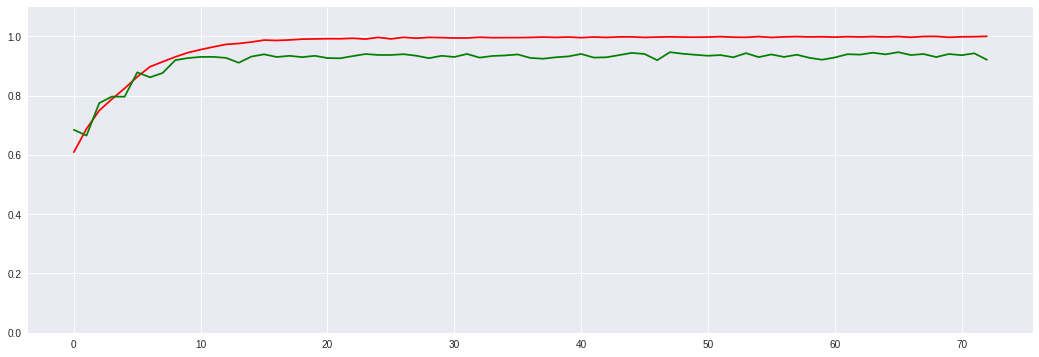

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 6))
plt.plot(train_acc_collect, "r")
plt.plot(valid_acc_collect, "g")
plt.ylim(0, 1.1)
plt.show()

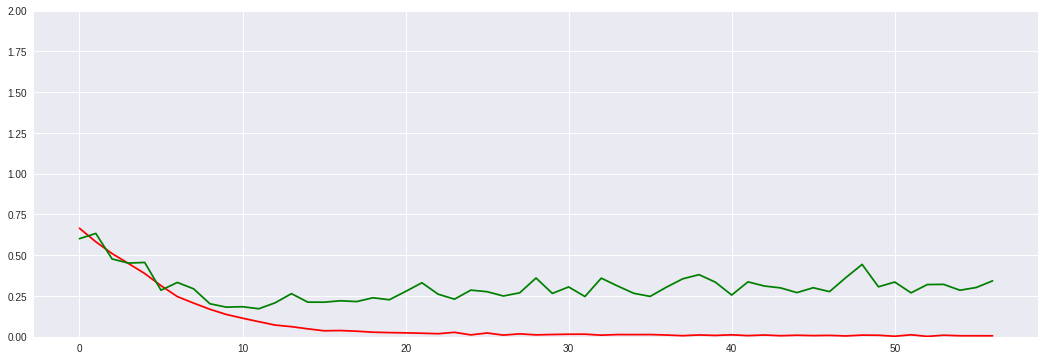

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 6))
plt.plot(train_loss_collect, "r")
plt.plot(valid_loss_collect, "g")
plt.ylim(0, 2.0)
plt.show()

## Save Trained Data

In [27]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Text file.
file = drive.CreateFile({'parents':[{u'id':'1W4z9HwbhYu2h0KCF2iucLQo0L_fsYeXW'}]})
file.SetContentFile('./checkpoint/ckpt.t7')  # VM에 저장되어 있는  example.txt 파일을 업로드
file.Upload()
print('Uploaded file with ID {}'.format(file.get('id')))

Uploaded file with ID 1CPIGvkDNcRRY-wzL2eNck-SKqFUKgzXs


In [0]:
train_stat = pd.DataFrame()

In [0]:
train_stat['TrainAccRate'] = train_acc_collect[:best_epoch+1]
train_stat['ValidAccRate'] = valid_acc_collect[:best_epoch+1]
train_stat['TrainLoss'] = train_loss_collect[:best_epoch+1]  
train_stat['ValidLoss'] = valid_loss_collect[:best_epoch+1]

In [30]:
train_stat.tail()

,TrainAccRate,ValidAccRate,TrainLoss,ValidLoss
39,0.99750,0.9322,0.008384,0.334942
40,0.99535,0.9404,0.012155,0.256022
41,0.99760,0.9282,0.007183,0.336895
42,0.99615,0.9292,0.010922,0.311445
43,0.99790,0.9366,0.006549,0.299796


In [31]:
stat_file_name = '[{:2.1f}, Resnet, Adam, Norm,  25000] test_stat.csv'.format(best_acc.cpu().numpy())
print(stat_file_name)

[94.4, Resnet, Adam, Norm,  25000] test_stat.csv


In [0]:
train_stat.to_csv(stat_file_name, index=False)

In [33]:
# Text file.
file = drive.CreateFile({'parents':[{u'id':'1W4z9HwbhYu2h0KCF2iucLQo0L_fsYeXW'}]})
file.SetContentFile(stat_file_name)  # VM에 저장되어 있는  example.txt 파일을 업로드
file.Upload()
print('Uploaded file with ID {}'.format(file.get('id')))

Uploaded file with ID 1OhiL4UIp4lX810gtzvyqYLerQOt-E36C


In [0]:
# 2. Get the file
# downloaded = drive.CreateFile({'id':'1XvUD8dy9l-qtCcTVPclVrUo_U9ORtHse'}) # replace the id with id of file you want to access
# downloaded.GetContentFile('test.zip')

In [24]:
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')

IndentationError: ignored

## Pytorch 0.3.0 Error

volatile의 값을 조정해본다.

https://discuss.pytorch.org/t/using-volatile-true-for-prediction-uses-more-gpu-memory-than-volatile-false/8330

In [0]:
a = Variable(a, volatile=True)
b = Variable(b, volatile=False)
c = Variable(c, volatile=True)
d = Variable(d, volatile=True)